In [1]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import os
import torch
import trimesh
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split

def mesh_to_pointcloud(mesh, num_points=1024, normalize=True):
    """Convert a trimesh mesh object to a point cloud."""
    point_cloud = mesh.sample(num_points)  # Randomly sample points from mesh surface
    if normalize:
        point_cloud -= np.mean(point_cloud, axis=0)
        point_cloud /= np.max(np.linalg.norm(point_cloud, axis=1))
    return point_cloud.astype(np.float32)

class MeshDataset(Dataset):
    def __init__(self, root_dir, num_points=1024, transform=None):
        self.root_dir = root_dir
        self.num_points = num_points
        self.transform = transform
        self.samples = []

        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                obj_files = [f for f in os.listdir(class_dir) if f.endswith('.obj')]
                for obj_file in obj_files:
                    obj_path = os.path.join(class_dir, obj_file)
                    label = class_name 
                    self.samples.append((obj_path, label))

        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(set([s[1] for s in self.samples])))}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        obj_path, label = self.samples[idx]
        
        mesh = trimesh.load(obj_path)
        point_cloud = mesh_to_pointcloud(mesh, num_points=self.num_points, normalize=True)        
        
        label_idx = self.class_to_idx[label]

        if self.transform:
            point_cloud = self.transform(point_cloud)

        point_cloud_tensor = torch.tensor(point_cloud, dtype=torch.float32)
        label_tensor = torch.tensor(label_idx, dtype=torch.long)

        return point_cloud_tensor, label_tensor

root_dir = 'datasets/human'

dataset = MeshDataset(root_dir, num_points=1024)

dataset_size = len(dataset)
test_size = int(0.10 * dataset_size)
val_size = int(0.15 * dataset_size)
train_size = dataset_size - test_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print(f'Number of samples: {len(dataset)}')
print(f'Classes: {dataset.class_to_idx}')
print(f'Number of classes: {len(dataset.class_to_idx)}')
print(dataset.samples)
for i, count in enumerate(np.bincount([dataset.class_to_idx[s[1]] for s in dataset.samples])):
    print(f'Class {i} - {dataset.idx_to_class[i]}: {count} samples')

print('Train size:', len(train_dataset))
print('Validation size:', len(val_dataset))
print('Test size:', len(test_dataset))

Number of samples: 1850
Classes: {'bouncing': 0, 'crane': 1, 'handstand': 2, 'jumping': 3, 'march_1': 4, 'march_2': 5, 'samba': 6, 'squat_1': 7, 'squat_2': 8}
Number of classes: 9
[('datasets/human/crane/mesh_0170.obj', 'crane'), ('datasets/human/crane/mesh_0042.obj', 'crane'), ('datasets/human/crane/mesh_0102.obj', 'crane'), ('datasets/human/crane/mesh_0109.obj', 'crane'), ('datasets/human/crane/mesh_0085.obj', 'crane'), ('datasets/human/crane/mesh_0052.obj', 'crane'), ('datasets/human/crane/mesh_0000.obj', 'crane'), ('datasets/human/crane/mesh_0149.obj', 'crane'), ('datasets/human/crane/mesh_0061.obj', 'crane'), ('datasets/human/crane/mesh_0063.obj', 'crane'), ('datasets/human/crane/mesh_0036.obj', 'crane'), ('datasets/human/crane/mesh_0081.obj', 'crane'), ('datasets/human/crane/mesh_0077.obj', 'crane'), ('datasets/human/crane/mesh_0008.obj', 'crane'), ('datasets/human/crane/mesh_0019.obj', 'crane'), ('datasets/human/crane/mesh_0015.obj', 'crane'), ('datasets/human/crane/mesh_0103.ob

In [3]:
# import plotly.graph_objects as go

# def plot_point_cloud(point_cloud, title):
#     fig = go.Figure(data=[go.Scatter3d(
#         x=point_cloud[:, 0],
#         y=point_cloud[:, 1],
#         z=point_cloud[:, 2],
#         mode='markers',
#         marker=dict(size=2)
#     )])
#     fig.update_layout(title=title)
#     fig.show()


# pointclouds = {}
# for i, (point_cloud, label) in enumerate(dataset):
#     label = dataset.idx_to_class[label.item()]
#     if label not in pointclouds:
#       print(f'getting {label}')
#       pointclouds[label] = point_cloud
#     if len(pointclouds) == len(dataset.class_to_idx):
#         break
      
# for label, point_cloud in pointclouds.items():
#     plot_point_cloud(point_cloud, title=f'Class: {label}')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimplePointNet(nn.Module):
    def __init__(self, num_classes, input_dim=3):
        """
        Args:
            num_classes (int): Number of output classes.
            input_dim (int): Dimension of the input point cloud (default is 3 for x, y, z).
        """
        super(SimplePointNet, self).__init__()

        # Input transformation MLP
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 1024)

        # Batch normalization layers applied after the fully connected layers
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

        # Global feature vector aggregation
        self.maxpool = nn.MaxPool1d(1024)

        # Fully connected layers for classification
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, num_classes)

        # Batch normalization layers for the classification layers
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        # x: (batch_size, num_points, 3)
        batch_size = x.size(0)
        num_points = x.size(1)

        # Apply the first MLP layers
        x = F.relu(self.fc1(x))  # (batch_size, num_points, 64)
        x = self.bn1(x.transpose(1, 2)).transpose(1, 2)  # (batch_size, num_points, 64)
        
        x = F.relu(self.fc2(x))  # (batch_size, num_points, 128)
        x = self.bn2(x.transpose(1, 2)).transpose(1, 2)  # (batch_size, num_points, 128)
        
        x = F.relu(self.fc3(x))  # (batch_size, num_points, 1024)
        x = self.bn3(x.transpose(1, 2)).transpose(1, 2)  # (batch_size, num_points, 1024)

        # Global feature vector aggregation (max-pooling over points)
        x = x.permute(0, 2, 1)  # (batch_size, 1024, num_points)
        x = self.maxpool(x)  # (batch_size, 1024, 1)
        x = x.view(batch_size, -1)  # (batch_size, 1024)

        # Apply the fully connected layers for classification
        x = F.relu(self.bn4(self.fc4(x)))  # (batch_size, 512)
        x = F.relu(self.bn5(self.fc5(x)))  # (batch_size, 256)
        x = self.fc6(x)  # (batch_size, num_classes)

        return x


In [5]:
num_classes = len(dataset.class_to_idx)

model = SimplePointNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for point_clouds, labels in train_loader:
        outputs = model(point_clouds)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}')

    # Validation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for point_clouds, labels in val_loader:
            outputs = model(point_clouds)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')
    
    torch.save(model.state_dict(), f'checkpoints/pointnet_epoch_{epoch+1}.pth')

torch.save(model.state_dict(), 'checkpoints/pointnet.pth')

Epoch [1/10], Loss: 0.8759027617898855
Validation Accuracy: 27.08%
Epoch [2/10], Loss: 0.3160465901548212
Validation Accuracy: 86.64%
Epoch [3/10], Loss: 0.24584812806411224
Validation Accuracy: 94.22%
Epoch [4/10], Loss: 0.17526514307511123
Validation Accuracy: 93.50%
Epoch [5/10], Loss: 0.10127569497986273
Validation Accuracy: 97.47%
Epoch [6/10], Loss: 0.059917294356802646
Validation Accuracy: 95.31%
Epoch [7/10], Loss: 0.047694711734286764
Validation Accuracy: 94.58%
Epoch [8/10], Loss: 0.04925038805231452
Validation Accuracy: 97.83%
Epoch [9/10], Loss: 0.044586968470618805
Validation Accuracy: 93.86%
Epoch [10/10], Loss: 0.04515239897988398
Validation Accuracy: 100.00%


/tmp/ipykernel_14111/475426554.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load('checkpoints/pointnet_epoch_10.pth'))


Test Accuracy: 98.92%


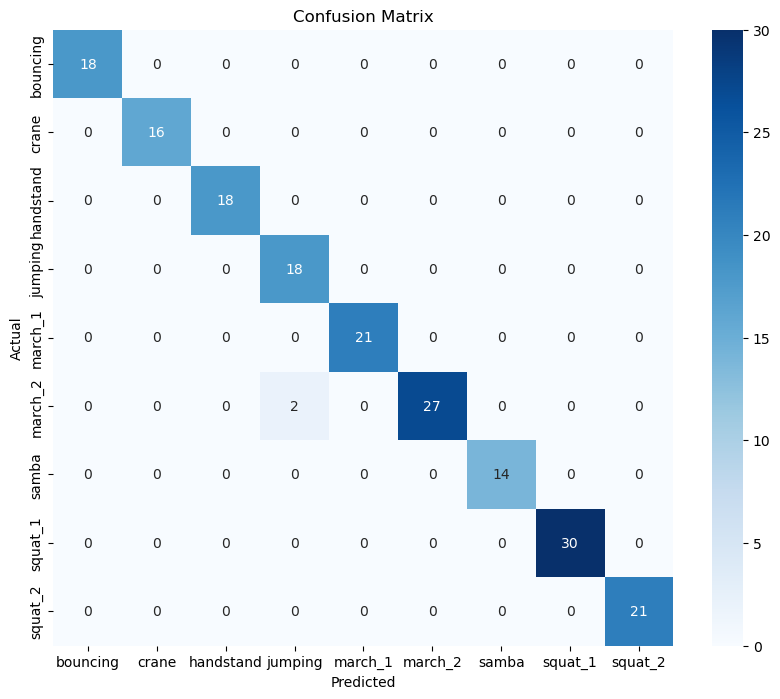

In [7]:
test_model = SimplePointNet(num_classes=num_classes)  
test_model.load_state_dict(torch.load('checkpoints/pointnet.pth'))
test_model.eval()

correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for point_clouds, labels in test_loader:
        outputs = model(point_clouds)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
        
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=dataset.idx_to_class.values(), yticklabels=dataset.idx_to_class.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()